In [49]:
import pandas as pd
import pandas_ta as ta

df = pd.read_csv("EURUSD_Candlestick_15_M_BID_01.02.2023-17.02.2024.csv")
df["Gmt time"]=df["Gmt time"].str.replace(".000","")
df['Gmt time']=pd.to_datetime(df['Gmt time'],format='%d.%m.%Y %H:%M:%S')
df=df[df.High!=df.Low]

In [50]:
df["EMA_slow"]=ta.ema(df.Close, length=50)
df["EMA_fast"]=ta.ema(df.Close, length=40)
df['ATR']=ta.atr(df.High, df.Low, df.Close, length=7)
df.reset_index(inplace=True, drop=True)

In [52]:
from statsmodels.nonparametric.kernel_regression import KernelReg
import numpy as np

def compute_envelopes(df, current_candle_index, backcandles, bw=3):
    # Slice the DataFrame to include only the past candles up to the current candle index
    start_index = max(current_candle_index - backcandles, 0)
    dfsample = df[start_index:current_candle_index + 1].copy()  # current candle included

    # Ensure the index is continuous for the kernel regression
    dfsample.reset_index(drop=True, inplace=True)

    # Create the Kernel Regression model
    X = dfsample.index
    model = KernelReg(endog=dfsample['Close'], exog=X, var_type='c', reg_type='lc', bw=[bw])
    fitted_values, _ = model.fit()

    # Calculate residuals and standard deviation of residuals
    residuals = dfsample['Close'] - fitted_values
    std_dev = 2. * np.std(residuals)
    # std_dev = dfsample['Close'].rolling(window=backcandles-1).std().iloc[-1]

    # Calculate the envelopes
    middle = fitted_values[-1]
    upper = middle + std_dev
    lower = middle - std_dev

    return middle, upper, lower

In [53]:
from tqdm import tqdm

# Parameters
backcandles = 10
bw = 7

# Initialize columns for the envelopes
df['Middle_Envelope'] = np.nan
df['Upper_Envelope'] = np.nan
df['Lower_Envelope'] = np.nan

# Compute envelopes for all candles
for current_candle_index in tqdm(range(backcandles, len(df))):
    middle, upper, lower = compute_envelopes(df, current_candle_index, backcandles, bw)
    df.at[current_candle_index, 'Middle_Envelope'] = middle
    df.at[current_candle_index, 'Upper_Envelope'] = upper
    df.at[current_candle_index, 'Lower_Envelope'] = lower

100%|██████████| 18166/18166 [00:18<00:00, 971.58it/s] 


In [54]:
df.tail()

,Gmt time,Open,High,Low,Close,Volume,EMA_slow,EMA_fast,ATR,Middle_Envelope,Upper_Envelope,Lower_Envelope
18171,2024-02-16 20:45:00,1.07744,1.07770,1.07729,1.07764,3288.91,1.076952,1.077122,0.000443,1.077855,1.078645,1.077065
18172,2024-02-16 21:00:00,1.07764,1.07771,1.07747,1.07763,1677.19,1.076979,1.077147,0.000414,1.077824,1.078546,1.077103
18173,2024-02-16 21:15:00,1.07763,1.07778,1.07758,1.07776,964.40,1.077010,1.077176,0.000384,1.077788,1.078509,1.077067
18174,2024-02-16 21:30:00,1.07777,1.07778,1.07761,1.07772,1957.77,1.077038,1.077203,0.000353,1.077741,1.078403,1.077079
18175,2024-02-16 21:45:00,1.07773,1.07775,1.07747,1.07749,1693.33,1.077055,1.077217,0.000343,1.077673,1.078217,1.077129


In [63]:
my_bbands = ta.bbands(df.Close, length=10, std=2)
df=df.join(my_bbands)

In [61]:
df.columns

Index(['Gmt time', 'Open', 'High', 'Low', 'Close', 'Volume', 'EMA_slow',
       'EMA_fast', 'ATR', 'Middle_Envelope', 'Upper_Envelope',
       'Lower_Envelope', 'BBL_30_2.0', 'BBM_30_2.0', 'BBU_30_2.0',
       'BBB_30_2.0', 'BBP_30_2.0', 'BBL_7_2.0', 'BBM_7_2.0', 'BBU_7_2.0',
       'BBB_7_2.0', 'BBP_7_2.0'],
      dtype='object')

In [64]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime

st = 9750
dfsample=df[st:st+100]


# Create a plot with 1 row
fig = make_subplots(rows=1, cols=1)

# Add candlestick plot with customized line colors
fig.add_trace(go.Candlestick(x=dfsample.index,
                             open=dfsample['Open'],
                             high=dfsample['High'],
                             low=dfsample['Low'],
                             close=dfsample['Close'],
                             increasing=dict(line=dict(color='rgba(0, 255, 0, 0.6)', width=0.1), # Red with transparency for increasing
                                             fillcolor='rgba(0, 255, 0, 0.6)'),  # Match fill color with line color
                             decreasing=dict(line=dict(color='rgba(0, 255, 0, 0.6)', width=0.1), # Green with transparency for decreasing
                                             fillcolor='rgba(255, 0, 0, 0.6)')), # Match fill color with line color
              row=1, col=1)

# Add Nadaraya-Watson fitted line
fig.add_trace(go.Scatter(x=dfsample.index, y=dfsample['Middle_Envelope'],
                         line=dict(color='green', width=2),
                         name="Nadaraya-Watson Fit"),
              row=1, col=1)

# Add upper standard deviation envelope
fig.add_trace(go.Scatter(x=dfsample.index, y=dfsample['Upper_Envelope'],
                         line=dict(color='rgba(0,0,255,0.2)'), # Light blue color
                         name='Upper Envelope',
                         showlegend=False),
              row=1, col=1)

# Add lower standard deviation envelope
fig.add_trace(go.Scatter(x=dfsample.index, y=dfsample['Lower_Envelope'],
                         line=dict(color='rgba(0,0,255,0.2)'), # Light blue color
                         name='Lower Envelope',
                         fill='tonexty', # This fills the area between this trace and the next trace
                         fillcolor='rgba(0,0,255,0.3)', # More opaque blue fill
                         showlegend=False),
              row=1, col=1)


# Add Bollinger Bands
fig.add_trace(go.Scatter(x=dfsample.index, y=dfsample['BBU_10_2.0'],
                         line=dict(color='rgba(0, 255, 0, 0.4)'),  # Upper Band
                         name='Upper Bollinger Band',
                         showlegend=True),
              row=1, col=1)

fig.add_trace(go.Scatter(x=dfsample.index, y=dfsample['BBM_10_2.0'],
                         line=dict(color='rgba(0, 255, 0, 0.6)'),  # Middle Band
                         name='Middle Bollinger Band',
                         fill='tonexty',
                         fillcolor='rgba(0, 255, 0, 0.1)',  # Light blue fill between the bands
                         showlegend=True),
              row=1, col=1)

fig.add_trace(go.Scatter(x=dfsample.index, y=dfsample['BBL_10_2.0'],
                         line=dict(color='rgba(0, 255, 0, 0.4)'),  # Lower Band
                         name='Lower Bollinger Band',
                         fill='tonexty',  # Fill between this line and the next upper band line
                         fillcolor='rgba(0, 255, 0, 0.1)',  # Light blue fill between the bands
                         showlegend=True),
              row=1, col=1)

# Update layout to set background color to black and remove gridlines
fig.update_layout(
    width=1000,
    height=600,
    sliders=[],
    paper_bgcolor='black',  # Set the background color of the entire figure
    plot_bgcolor='black',   # Set the background color of the plotting area
    xaxis_showgrid=False,   # Remove x-axis gridlines
    yaxis_showgrid=False,   # Remove y-axis gridlines
)

# Show the plot
fig.show()


In [65]:
def ema_signal(df, backcandles):
    # Create boolean Series for conditions
    above = df['EMA_fast'] > df['EMA_slow']
    below = df['EMA_fast'] < df['EMA_slow']

    # Rolling window to check if condition is met consistently over the window
    above_all = above.rolling(window=backcandles).apply(lambda x: x.all(), raw=True).fillna(0).astype(bool)
    below_all = below.rolling(window=backcandles).apply(lambda x: x.all(), raw=True).fillna(0).astype(bool)

    # Assign signals based on conditions
    df['EMASignal'] = 0  # Default no signal
    df.loc[above_all, 'EMASignal'] = 2  # Signal 2 where EMA_fast consistently above EMA_slow
    df.loc[below_all, 'EMASignal'] = 1  # Signal 1 where EMA_fast consistently below EMA_slow

    return df

df = df[-60000:]
df.reset_index(inplace=True, drop=True)
df = ema_signal(df,  7)

In [79]:
def total_signal_BB(df):
    # Vectorized conditions for total_signal
    condition_sell = (df['EMASignal'] == 2) & (df['Close'] <= df['BBL_10_2.0'])
    condition_buy = (df['EMASignal'] == 1) & (df['Close'] >= df['BBU_10_2.0'])

    # Assigning signals based on conditions
    df['Total_Signal'] = 0  # Default no signal
    df.loc[condition_sell, 'Total_Signal'] = 1
    df.loc[condition_buy, 'Total_Signal'] = 2

def total_signal_NW(df):
    # Vectorized conditions for total_signal
    condition_sell = (df['EMASignal'] == 2) & (df['Close'] <= df['Lower_Envelope'])
    condition_buy = (df['EMASignal'] == 1) & (df['Close'] >= df['Upper_Envelope'])

    # Assigning signals based on conditions
    df['Total_Signal'] = 0  # Default no signal
    df.loc[condition_sell, 'Total_Signal'] = 1
    df.loc[condition_buy, 'Total_Signal'] = 2

total_signal_BB(df)


In [80]:
df["TotalSignal"]=df.Total_Signal
df.TotalSignal.value_counts()

TotalSignal
0    17458
2      365
1      353
Name: count, dtype: int64

In [81]:
import numpy as np
def pointpos(x):
    if x['TotalSignal']==2:
        return x['Low']-1e-4
    elif x['TotalSignal']==1:
        return x['High']+1e-4
    else:
        return np.nan

df['pointpos'] = df.apply(lambda row: pointpos(row), axis=1)

In [82]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
st=0
dfpl = df[st:st+350]
# Create a plot with 2 rows
fig = make_subplots(rows=1, cols=1)

label = "30_2.0"

# Add candlestick plot on the first row
fig.add_trace(go.Candlestick(x=dfpl.index,
                             open=dfpl['Open'],
                             high=dfpl['High'],
                             low=dfpl['Low'],
                             close=dfpl['Close']),
              row=1, col=1)

# Add Bollinger Bands, EMA lines on the same subplot
fig.add_trace(go.Scatter(x=dfpl.index, y=dfpl['BBL_'+label],
                         line=dict(color='green', width=1),
                         name="BBL"),
              row=1, col=1)
fig.add_trace(go.Scatter(x=dfpl.index, y=dfpl['BBU_'+label],
                         line=dict(color='green', width=1),
                         name="BBU"),
              row=1, col=1)
fig.add_trace(go.Scatter(x=dfpl.index, y=dfpl['EMA_fast'],
                         line=dict(color='black', width=1),
                         name="EMA_fast"),
              row=1, col=1)
fig.add_trace(go.Scatter(x=dfpl.index, y=dfpl['EMA_slow'],
                         line=dict(color='blue', width=1),
                         name="EMA_slow"),
              row=1, col=1)

# Add markers for trade entry points on the same subplot
fig.add_trace(go.Scatter(x=dfpl.index, y=dfpl['pointpos'], mode="markers",
                         marker=dict(size=8, color="MediumPurple"),
                         name="entry"),
              row=1, col=1)

fig.update_layout(width=1200, height=800, sliders=[])
fig.show()

In [83]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime

st = 5000
dfsample=df[st:st+100]


# Create a plot with 1 row
fig = make_subplots(rows=1, cols=1)

# Add candlestick plot with customized line colors
fig.add_trace(go.Candlestick(x=dfsample.index,
                             open=dfsample['Open'],
                             high=dfsample['High'],
                             low=dfsample['Low'],
                             close=dfsample['Close'],
                             increasing=dict(line=dict(color='rgba(0, 255, 0, 0.6)', width=0.1), # Red with transparency for increasing
                                             fillcolor='rgba(0, 255, 0, 0.6)'),  # Match fill color with line color
                             decreasing=dict(line=dict(color='rgba(0, 255, 0, 0.6)', width=0.1), # Green with transparency for decreasing
                                             fillcolor='rgba(255, 0, 0, 0.6)')), # Match fill color with line color
              row=1, col=1)

# Add Nadaraya-Watson fitted line
fig.add_trace(go.Scatter(x=dfsample.index, y=dfsample['Middle_Envelope'],
                         line=dict(color='green', width=2),
                         name="Nadaraya-Watson Fit"),
              row=1, col=1)

# Add upper standard deviation envelope
fig.add_trace(go.Scatter(x=dfsample.index, y=dfsample['Upper_Envelope'],
                         line=dict(color='rgba(0,0,255,0.2)'), # Light blue color
                         name='Upper Envelope',
                         showlegend=False),
              row=1, col=1)

# Add lower standard deviation envelope
fig.add_trace(go.Scatter(x=dfsample.index, y=dfsample['Lower_Envelope'],
                         line=dict(color='rgba(0,0,255,0.2)'), # Light blue color
                         name='Lower Envelope',
                         fill='tonexty', # This fills the area between this trace and the next trace
                         fillcolor='rgba(0,0,255,0.3)', # More opaque blue fill
                         showlegend=False),
              row=1, col=1)


# Add Bollinger Bands
# fig.add_trace(go.Scatter(x=dfsample.index, y=dfsample['BBU_30_2.0'],
#                          line=dict(color='rgba(0, 255, 0, 0.4)'),  # Upper Band
#                          name='Upper Bollinger Band',
#                          showlegend=True),
#               row=1, col=1)

# fig.add_trace(go.Scatter(x=dfsample.index, y=dfsample['BBM_30_2.0'],
#                          line=dict(color='rgba(0, 255, 0, 0.6)'),  # Middle Band
#                          name='Middle Bollinger Band',
#                          fill='tonexty',
#                          fillcolor='rgba(0, 255, 0, 0.1)',  # Light blue fill between the bands
#                          showlegend=True),
#               row=1, col=1)

# fig.add_trace(go.Scatter(x=dfsample.index, y=dfsample['BBL_30_2.0'],
#                          line=dict(color='rgba(0, 255, 0, 0.4)'),  # Lower Band
#                          name='Lower Bollinger Band',
#                          fill='tonexty',  # Fill between this line and the next upper band line
#                          fillcolor='rgba(0, 255, 0, 0.1)',  # Light blue fill between the bands
#                          showlegend=True),
#               row=1, col=1)

fig.add_trace(go.Scatter(x=dfsample.index, y=dfsample['EMA_fast'],
                         line=dict(color='pink', width=1),
                         name="EMA_fast"),
              row=1, col=1)
fig.add_trace(go.Scatter(x=dfsample.index, y=dfsample['EMA_slow'],
                         line=dict(color='yellow', width=1),
                         name="EMA_slow"),
              row=1, col=1)

# Add markers for trade entry points on the same subplot
fig.add_trace(go.Scatter(x=dfsample.index, y=dfsample['pointpos'], mode="markers",
                         marker=dict(size=8, color="MediumPurple"),
                         name="entry"),
              row=1, col=1)

# Update layout to set background color to black and remove gridlines
fig.update_layout(
    width=1000,
    height=600,
    sliders=[],
    paper_bgcolor='black',  # Set the background color of the entire figure
    plot_bgcolor='black',   # Set the background color of the plotting area
    xaxis_showgrid=False,   # Remove x-axis gridlines
    yaxis_showgrid=False,   # Remove y-axis gridlines
)

# Show the plot
fig.show()


In [84]:
from backtesting import Strategy
from backtesting import Backtest

dfopt = df[0:]
def SIGNAL():
    return dfopt.TotalSignal

class MyStrat(Strategy):
    mysize = 3000
    slcoef = 1.1
    TPSLRatio = 1.5
    
    def init(self):
        super().init()
        self.signal1 = self.I(SIGNAL)

    def next(self):
        super().next()
        slatr = self.slcoef*self.data.ATR[-1]
        TPSLRatio = self.TPSLRatio
       
        if self.signal1==2 and len(self.trades)==0:
            sl1 = self.data.Close[-1] - slatr
            tp1 = self.data.Close[-1] + slatr*TPSLRatio
            self.buy(sl=sl1, tp=tp1, size=self.mysize)
        
        elif self.signal1==1 and len(self.trades)==0:         
            sl1 = self.data.Close[-1] + slatr
            tp1 = self.data.Close[-1] - slatr*TPSLRatio
            self.sell(sl=sl1, tp=tp1, size=self.mysize)

bt = Backtest(dfopt, MyStrat, cash=250, margin=1/30)
stats, heatmap = bt.optimize(slcoef=[i/10 for i in range(8, 26)],
                    TPSLRatio=[i/10 for i in range(8, 26)],
                    maximize='Return [%]', max_tries=400,
                        random_state=0,
                        return_heatmap=True)
stats

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_1292\2701522179.py:32: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.

f:\Python\Lib\site-packages\backtesting\backtesting.py:1488: UserWarning:

Searching for best of 324 configurations.



Start                                     0.0
End                                   18175.0
Duration                              18175.0
Exposure Time [%]                   50.731734
Equity Final [$]                      641.666
Equity Peak [$]                     685.88508
Return [%]                           156.6664
Buy & Hold Return [%]               -0.787264
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                  -13.667317
Avg. Drawdown [%]                   -1.375172
Max. Drawdown Duration                 2738.0
Avg. Drawdown Duration              88.882979
# Trades                                285.0
Win Rate [%]                        40.350877
Best Trade [%]                        1.31175
Worst Trade [%]                     -0.659782
Avg. Trade [%]                    

In [85]:
stats["_strategy"]

<Strategy MyStrat(slcoef=2.5,TPSLRatio=1.8)>

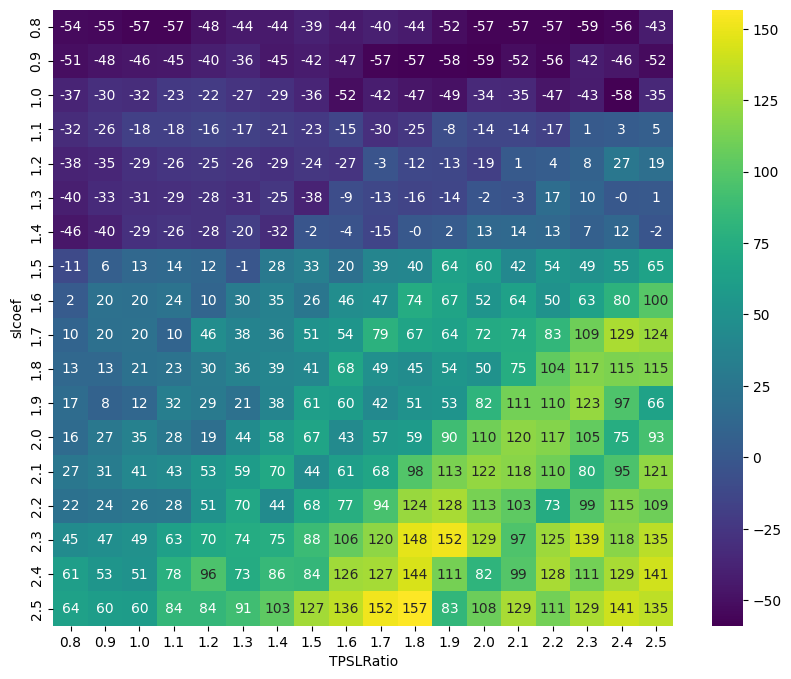

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Convert multiindex series to dataframe
heatmap_df = heatmap.unstack()
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_df, annot=True, cmap='viridis', fmt='.0f')
plt.show()

In [69]:
bt.plot()

c:\CodeLab\Python\Lib\site-packages\backtesting\_plotting.py:659: UserWarning:

found multiple competing values for 'toolbar.active_drag' property; using the latest value

c:\CodeLab\Python\Lib\site-packages\backtesting\_plotting.py:659: UserWarning:

found multiple competing values for 'toolbar.active_scroll' property; using the latest value



GridPlot(id='p2631', ...)

In [62]:
from backtesting import Strategy
from backtesting import Backtest

dftest = df[:]
def SIGNAL():
    return dftest.TotalSignal

class MyStrat(Strategy):
    mysize = 3000
    slcoef = 2.2
    TPSLRatio = 2.2
    
    def init(self):
        super().init()
        self.signal1 = self.I(SIGNAL)

    def next(self):
        super().next()
        slatr = self.slcoef*self.data.ATR[-1]
        TPSLRatio = self.TPSLRatio
       
        if self.signal1==2 and len(self.trades)==0:
            sl1 = self.data.Close[-1] - slatr
            tp1 = self.data.Close[-1] + slatr*TPSLRatio
            self.buy(sl=sl1, tp=tp1, size=self.mysize)
        
        elif self.signal1==1 and len(self.trades)==0:         
            sl1 = self.data.Close[-1] + slatr
            tp1 = self.data.Close[-1] - slatr*TPSLRatio
            self.sell(sl=sl1, tp=tp1, size=self.mysize)

bt = Backtest(dftest, MyStrat, cash=250, margin=1/30, commission=0.0002)
bt.run()

C:\Users\710177\AppData\Local\Temp\ipykernel_5404\227353489.py:32: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Start                                     0.0
End                                   18175.0
Duration                              18175.0
Exposure Time [%]                   43.166813
Equity Final [$]                   322.638961
Equity Peak [$]                    384.746972
Return [%]                          29.055584
Buy & Hold Return [%]               -0.787264
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                  -30.875278
Avg. Drawdown [%]                   -3.521704
Max. Drawdown Duration                 6264.0
Avg. Drawdown Duration             325.240741
# Trades                                210.0
Win Rate [%]                        33.333333
Best Trade [%]                       1.141222
Worst Trade [%]                     -0.778732
Avg. Trade [%]                    

In [87]:
bt.plot()

f:\Python\Lib\site-packages\backtesting\_plotting.py:659: UserWarning:

found multiple competing values for 'toolbar.active_drag' property; using the latest value

f:\Python\Lib\site-packages\backtesting\_plotting.py:659: UserWarning:

found multiple competing values for 'toolbar.active_scroll' property; using the latest value



GridPlot(id='p1307', ...)